In [1]:

from logging import root
from pickle import FALSE
from statistics import mean
from unittest import load_tests
import numpy as np
import pdb
import torch
import sys
sys.path.append("../")
from utils import *
sys.path.append("../forward_model/")
from model import *
import dataloader
import matplotlib.pyplot as plt
sys.path.append("")
from solve_inverse import *

from functools import partial
import loss
from glob import glob
import matplotlib.animation as animation
from os.path import exists
sys.path.append("../prior/")
from encoder_model import *
import shutil

import configargparse

### load data

In [2]:
batch_size = 50
x,y,_,_= dataloader.load_file_frequency(sample_num=400,type="scatter_field_f")
x_train = torch.tensor(x[:350*50,:,:,:]).float()
x_test = torch.tensor(x[350*50:,:,:,:]).float()
y_train = torch.tensor(y[:350*50,:,:,:]).float()
y_test = torch.tensor(y[350*50:,:,:,:]).float()

x_normalizer = dataloader.UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = dataloader.UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

x_original,y_original,_,_= dataloader.load_file_frequency(start_num =350, sample_num=50,type='scatter_field_f',normalize=0)
y_test = torch.tensor(y_original).float()
y_test = y_normalizer.encode(y_test)
y_normalizer.cuda()

test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

y_norm = y_normalizer
y_norm.cuda()

# get one test sample for demo
for i, (x,y) in enumerate(test_loader):
    break

In [3]:
complex_weight = np.load("../data/v1/normalize_complex_coeff.npy")
weight = torch.zeros([50,1,1,2]).cuda()
weight[:,:,:,0] = torch.tensor(complex_weight.real).cuda()
weight[:,:,:,1] = torch.tensor(complex_weight.imag).cuda()

### load model

In [4]:
log_dir = glob("../model_zoo/forward_model/*noise_{}*born*/fno_born_{}_{}_350_50_current.pth".format(0,5,128))[0]
model = (torch.load(log_dir,map_location="cuda:0")).cuda()
model.eval()

FNO2d_weight_tight_born(
  (fc_inc): Linear(in_features=4, out_features=128, bias=True)
  (fc_eps): Linear(in_features=3, out_features=128, bias=True)
  (conv0): SpectralConv2d_born()
  (w0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [5]:
prior_path = glob("../model_zoo/priors/*latent_size_{}*/*/model_final.pth".format(64))[0]
prior = ConvAutoencoder(1,64).cuda()
prior.load_state_dict(torch.load(prior_path))
prior.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): 

### generate mask

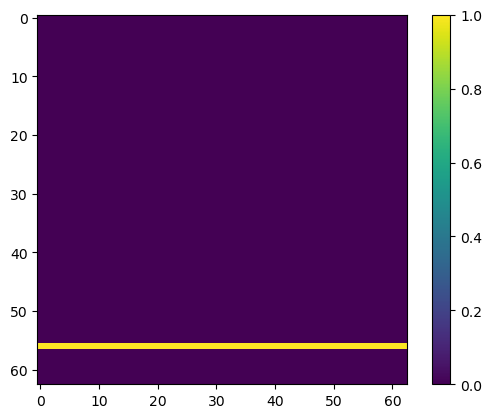

In [6]:
mask = torch.zeros([63,63,2]).cuda()
mask[56,:,:] = 1
plt.imshow(mask[:,:,0].detach().cpu().numpy());plt.colorbar();


### solve inverse problem       

In [7]:
gt_dynamics = y
inputs = x[:,:,:,1:]
gt_eps = x[0,:,:,[0]].cuda()
loss_fn = partial(loss.mse)

Adjusting learning rate of group 0 to 1.0000e-02.


  0%|          | 0/1200 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.
use 10 frequenies
eps mse:0.76, u mse:0.02
start piviting
use 20 frequenies
eps mse:0.05, u mse:0.00
Adjusting learning rate of group 0 to 2.5000e-03.
use 40 frequenies
eps mse:0.06, u mse:0.00
Adjusting learning rate of group 0 to 1.2500e-03.
use 50 frequenies
eps mse:0.06, u mse:0.00


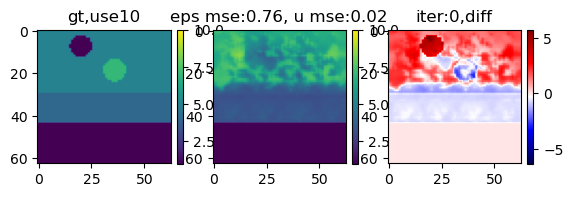

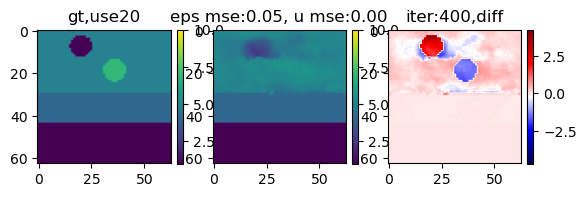

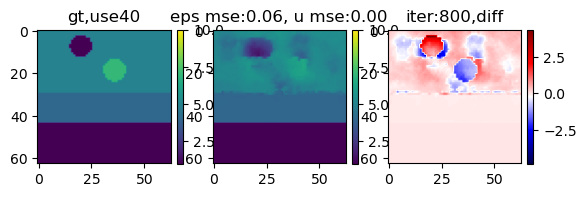

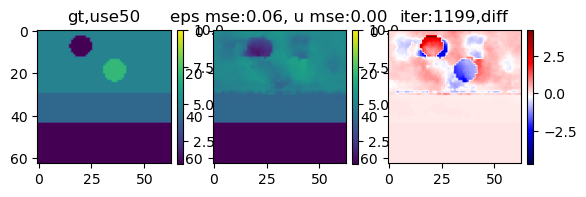

In [8]:
eps_estimated, losses, mse, mses_decoded = solve_inverse_frequency(model, inputs, gt_dynamics, loss_fn, mask=mask,
                            num_iter=1200,prior=prior, init_val=1, device="cuda",
                            lr = 0.01, plot=True, gt_eps=gt_eps,normalizer=x_normalizer,pivit=True,optimizer="adam",pivit_iter=300,
                            incremental_freq=1,save=False,root_path=None,tv_reg=0.01,drop_reg_high=False,
                            filter=1,gamma=0.5,y_normalizer=y_norm,weight=weight,load_weight=True,)